In [1]:
import theano
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D, ZeroPadding1D
from keras.optimizers import SGD
import numpy as np
import os
import matplotlib.pyplot as plt

Using Theano backend.


In [2]:
feat_0_path='data/mon_exp/feat/0'
feat_1_path='data/mon_exp/feat/1'
#max_feat_count=7500

def get_feats(feat_0_path, feat_1_path, max_feat_count):
    feats_0_list = []
    for fil in os.listdir(feat_0_path):
        feats = []
        with open(os.path.join(feat_0_path, fil)) as f:
            feats = f.readlines()
            feats = [float(line) for line in feats]
        feats = np.array(feats)
        feats1 = np.zeros(max_feat_count)
        length = min(len(feats), max_feat_count)
        feats1[:length] = feats[:length]
        #print len(feats)
        feats_0_list.append(feats1)

    feats_1_list = []
    for fil in os.listdir(feat_1_path):
        feats = []
        with open(os.path.join(feat_1_path, fil)) as f:
            feats = f.readlines()
            feats = [float(line) for line in feats]
        feats = np.array(feats)
        feats1 = np.zeros(max_feat_count)
        length = min(len(feats), max_feat_count)
        feats1[:length] = feats[:length]
        #print len(feats1)
        feats_1_list.append(feats1)
    return feats_0_list, feats_1_list  

In [3]:
#num_test=100
def split(num_test, feats_0_list, feats_1_list):
    f0 = np.array(feats_0_list)
    f1 = np.array(feats_1_list)
    f1 = np.repeat(f1, 9, axis=0)
    print f0.shape
    print f1.shape
    f0_tr = f0[:-num_test, :]
    f1_tr = f1[:-num_test, :]
    print f0_tr.shape
    print f1_tr.shape
    f0_ts = f0[-num_test:, :]
    f1_ts = f1[-num_test:, :]
    print f0_ts.shape
    print f1_ts.shape
    return f0_tr, f1_tr, f0_ts, f1_ts

In [4]:
def append_labels(f0_tr, f1_tr, f0_ts, f1_ts):
    lab_0_tr = np.zeros((f0_tr.shape[0],2))
    lab_1_tr = np.zeros((f1_tr.shape[0],2))
    lab_0_ts = np.zeros((f0_ts.shape[0],2))
    lab_1_ts = np.zeros((f1_ts.shape[0],2))

    lab_0_tr[:,0] = 1
    lab_1_tr[:,1] = 1
    lab_0_ts[:,0] = 1
    lab_1_ts[:,1] = 1

    print lab_0_tr.shape
    x_0_tr = np.append(f0_tr,lab_0_tr, axis=1)
    x_1_tr = np.append(f1_tr, lab_1_tr, axis=1)
    print x_0_tr.shape
    x_0_ts = np.append(f0_ts, lab_0_ts, axis=1)
    x_1_ts = np.append(f1_ts, lab_1_ts, axis=1)
    return x_0_tr, lab_0_tr, x_1_tr, lab_1_tr, x_0_ts, lab_0_ts, x_1_ts, lab_1_ts

In [5]:
def get_shuffled( max_feat_count, x_0_tr, lab_0_tr, x_1_tr, lab_1_tr, x_0_ts, lab_0_ts, x_1_ts, lab_1_ts):
    x_tr = np.vstack([x_0_tr, x_1_tr])
    print x_tr.shape
    x_ts = np.vstack([x_0_ts, x_1_ts])
    np.random.shuffle(x_tr)
    np.random.shuffle(x_ts)
    X_tr = x_tr[:, 0:max_feat_count]
    y_tr = x_tr[:, max_feat_count:]
    X_ts = x_ts[:, 0:max_feat_count]
    y_ts = x_ts[:, max_feat_count:]
    print X_tr.shape
    print y_tr.shape
    print X_ts.shape
    print y_ts.shape
    return X_tr, y_tr, X_ts, y_ts

In [6]:
def VGG_16(max_len, weights_path=None):
    model = Sequential()
    model.add(ZeroPadding1D((1,1),input_shape=(1, max_len)))
    model.add(Conv1D(256, (3, ), activation='relu'))
    model.add(ZeroPadding1D((1,1)))
    model.add(Conv1D(256, (3, ), activation='relu'))
    #model.add(MaxPooling2D((2,2), strides=(2,2)))
    print model.output_shape
    model.add(ZeroPadding1D((1,1)))
    model.add(Conv1D(128, (3, ), activation='relu'))
    model.add(ZeroPadding1D((1,1)))
    model.add(Conv1D(128, (3, ), activation='relu'))
    #print "Before max pool %s" %str(model.output_shape)
    #model.add(MaxPooling1D(pool_size=1, strides=1))
    #print model.output_shape
    model.add(ZeroPadding1D((1,1)))
    model.add(Conv1D(64, (3, ), activation='relu'))
    model.add(ZeroPadding1D((1,1)))
    model.add(Conv1D(64, (3, ), activation='relu'))
    model.add(ZeroPadding1D((1,1)))
    model.add(Conv1D(64, (3, ), activation='relu'))
    #print model.output_shape
    #model.add(MaxPooling1D(2, strides=2))
    #print model.output_shape
    model.add(ZeroPadding1D((1,1)))
    model.add(Conv1D(32, (3, ), activation='relu'))
    model.add(ZeroPadding1D((1,1)))
    model.add(Conv1D(32, (3, ), activation='relu'))
    model.add(ZeroPadding1D((1,1)))
    model.add(Conv1D(32, (3, ), activation='relu'))
    #model.add(MaxPooling1D(2, strides=2))
    #print model.output_shape
    '''
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    '''
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    '''model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='relu'))
    model.add(Dropout(0.5))'''
    
    
    if weights_path:
        model.load_weights(weights_path)

    return model


In [7]:
print theano.__version__
import keras.backend as K
K.set_image_dim_ordering('th')
print K.image_dim_ordering()
input_shape=(1,max_feat_count)
print all(input_shape[1:])
from theano import ifelse
print theano.ifelse.ifelse

0.10.0dev1.dev-d51233517debf3a1231a33058d65e8f969db923d
th


NameError: name 'max_feat_count' is not defined

In [15]:
def get_model(max_feat_count, vgg = False):
    if not vgg:
        model = Sequential()
        model.add(Dense(2, activation='relu', input_dim=max_feat_count))
        model.add(Dense(2, activation='softmax' ))
        #model.add(Dense(2, activation='softmax',input_dim=max_feat_count ))
    else:
        model = VGG_16(max_feat_count)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']  )
    return model

In [8]:
def reshape(X_tr, X_ts, vgg = False):
    if vgg:
        X_tr = X_tr.reshape(X_tr.shape[0], 1, X_tr.shape[1])
        X_ts = X_ts.reshape(X_ts.shape[0], 1, X_ts.shape[1])
    return X_tr, X_ts

In [9]:
def train_model(model, X_tr, y_tr, batch_siz=32, epoch=10):
    return model.fit(X_tr, y_tr, batch_size=batch_siz, epochs=epoch)

In [10]:
def test_model(model, X_ts, y_ts):
    return model.evaluate(X_ts, y_ts, batch_size=X_ts.shape[0])

In [89]:
print X_tr.shape
print y_tr.shape
print model.summary()

(5495, 1, 7000)
(5495, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 2)                 14002     
Total params: 14,002
Trainable params: 14,002
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
def run(feat_0_path, feat_1_path, max_feat_count, num_test, vgg=False, batch_size=32, epochs=10):
    X_tr, y_tr, X_ts, y_ts = get_shuffled( max_feat_count, *append_labels( *split( num_test, \
                                                        *get_feats(feat_0_path, feat_1_path, max_feat_count) ) ) )
    X_tr, X_ts = reshape(X_tr, X_ts, vgg)
    model = get_model(max_feat_count, vgg)
    h_tr = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs)
    l_tr = h_tr.history['loss'][-1]
    a_tr = h_tr.history['acc'][-1]
    print l_tr
    print a_tr
    h_ts = model.evaluate(X_ts, y_ts, batch_size=X_ts.shape[0])
    l_ts = h_ts[0]
    a_ts = h_ts[1]
    print l_ts
    print a_ts
    return l_tr, a_tr, l_ts, a_ts

In [12]:
def batch(feat_0_path, feat_1_path, num_test, start_feat, end_feat, step_feat=100, vgg=False):
    tr_loss = []; tr_acc = []; ts_loss = []; ts_acc = []
    for feat in xrange(start_feat, end_feat, step_feat):
        print "Starting run - max_feat_count = %d"%feat
        l_tr, a_tr, l_ts, a_ts = run(feat_0_path, feat_1_path, feat, num_test, vgg)
        tr_loss.append(l_tr)
        tr_acc.append(a_tr)
        ts_loss.append(l_ts)
        ts_acc.append(a_ts)
    return tr_loss, tr_acc, ts_loss, ts_acc    

In [18]:
feat_0_path='data/mon_exp/feat/0'
feat_1_path='data/mon_exp/feat/1'
num_test=100
start_feat = 500
end_feat = 10000
step_feat = 100
vgg = False
tr_loss, tr_acc, ts_loss, ts_acc = batch(feat_0_path, feat_1_path, num_test, start_feat, end_feat, step_feat, vgg)

Starting run - max_feat_count = 500
(2815, 500)
(2880, 500)
(2715, 500)
(2780, 500)
(100, 500)
(100, 500)
(2715, 2)
(2715, 502)
(5495, 502)
(5495, 500)
(5495, 2)
(200, 500)
(200, 2)
Epoch 1/10
5495/5495 [==============================] - 0s - loss: 0.6187 - acc: 0.6237     
Epoch 2/10
5495/5495 [==============================] - 0s - loss: 0.5282 - acc: 0.7378     
Epoch 3/10
5495/5495 [==============================] - 0s - loss: 0.4724 - acc: 0.7689     
Epoch 4/10
5495/5495 [==============================] - 0s - loss: 0.4364 - acc: 0.7818     
Epoch 5/10
5495/5495 [==============================] - 0s - loss: 0.4117 - acc: 0.7914     
Epoch 6/10
5495/5495 [==============================] - 0s - loss: 0.3946 - acc: 0.8035     
Epoch 7/10
5495/5495 [==============================] - 0s - loss: 0.3814 - acc: 0.8140     
Epoch 8/10
5495/5495 [==============================] - 0s - loss: 0.3709 - acc: 0.8173     
Epoch 9/10
5495/5495 [==============================] - 0s - loss: 0.3610 

5495/5495 [==============================] - 0s - loss: 0.3332 - acc: 0.8218     
Epoch 9/10
5495/5495 [==============================] - 0s - loss: 0.3265 - acc: 0.8359     
Epoch 10/10
5495/5495 [==============================] - 0s - loss: 0.3212 - acc: 0.8386     
0.321157849171
0.838580527753
200/200 [==============================] - 0s
0.547248906027
0.75
Starting run - max_feat_count = 1200
(2815, 1200)
(2880, 1200)
(2715, 1200)
(2780, 1200)
(100, 1200)
(100, 1200)
(2715, 2)
(2715, 1202)
(5495, 1202)
(5495, 1200)
(5495, 2)
(200, 1200)
(200, 2)
Epoch 1/10
5495/5495 [==============================] - 0s - loss: 0.5981 - acc: 0.6468     
Epoch 2/10
5495/5495 [==============================] - 0s - loss: 0.4999 - acc: 0.6994     
Epoch 3/10
5495/5495 [==============================] - 0s - loss: 0.4618 - acc: 0.7445     
Epoch 4/10
5495/5495 [==============================] - 0s - loss: 0.4401 - acc: 0.7751     
Epoch 5/10
5495/5495 [==============================] - 0s - loss: 0.4

5495/5495 [==============================] - 0s - loss: 0.4347 - acc: 0.8351     
Epoch 5/10
5495/5495 [==============================] - 0s - loss: 0.4067 - acc: 0.8369     
Epoch 6/10
5495/5495 [==============================] - 0s - loss: 0.3854 - acc: 0.8431     
Epoch 7/10
5495/5495 [==============================] - 0s - loss: 0.3686 - acc: 0.8449     
Epoch 8/10
5495/5495 [==============================] - 0s - loss: 0.3541 - acc: 0.8491     
Epoch 9/10
5495/5495 [==============================] - 0s - loss: 0.3432 - acc: 0.8511     
Epoch 10/10
5495/5495 [==============================] - 0s - loss: 0.3339 - acc: 0.8548     
0.333922180813
0.854777070064
200/200 [==============================] - 0s
0.502642578179
0.735
Starting run - max_feat_count = 1900
(2815, 1900)
(2880, 1900)
(2715, 1900)
(2780, 1900)
(100, 1900)
(100, 1900)
(2715, 2)
(2715, 1902)
(5495, 1902)
(5495, 1900)
(5495, 2)
(200, 1900)
(200, 2)
Epoch 1/10
5495/5495 [==============================] - 0s - loss: 0.

Epoch 1/10
5495/5495 [==============================] - 0s - loss: 0.6119 - acc: 0.6569     
Epoch 2/10
5495/5495 [==============================] - 0s - loss: 0.5743 - acc: 0.6961     
Epoch 3/10
5495/5495 [==============================] - 0s - loss: 0.5583 - acc: 0.7194     
Epoch 4/10
5495/5495 [==============================] - 0s - loss: 0.5495 - acc: 0.7245     
Epoch 5/10
5495/5495 [==============================] - 0s - loss: 0.5431 - acc: 0.7274     
Epoch 6/10
5495/5495 [==============================] - 0s - loss: 0.5389 - acc: 0.7316     
Epoch 7/10
5495/5495 [==============================] - 0s - loss: 0.5348 - acc: 0.7325     
Epoch 8/10
5495/5495 [==============================] - 0s - loss: 0.5326 - acc: 0.7338     
Epoch 9/10
5495/5495 [==============================] - 0s - loss: 0.5297 - acc: 0.7352     
Epoch 10/10
5495/5495 [==============================] - 0s - loss: 0.5279 - acc: 0.7354     
0.527936976883
0.735395814377
200/200 [==============================

5495/5495 [==============================] - 0s - loss: 0.4062 - acc: 0.8200     
Epoch 10/10
5495/5495 [==============================] - 0s - loss: 0.4017 - acc: 0.8222     
0.401738063455
0.82220200182
200/200 [==============================] - 0s
0.515556241768
0.74
Starting run - max_feat_count = 3200
(2815, 3200)
(2880, 3200)
(2715, 3200)
(2780, 3200)
(100, 3200)
(100, 3200)
(2715, 2)
(2715, 3202)
(5495, 3202)
(5495, 3200)
(5495, 2)
(200, 3200)
(200, 2)
Epoch 1/10
5495/5495 [==============================] - 0s - loss: 0.6060 - acc: 0.6535     
Epoch 2/10
5495/5495 [==============================] - 0s - loss: 0.5480 - acc: 0.7234     
Epoch 3/10
5495/5495 [==============================] - 0s - loss: 0.5240 - acc: 0.7401     
Epoch 4/10
5495/5495 [==============================] - 0s - loss: 0.5093 - acc: 0.7529     
Epoch 5/10
5495/5495 [==============================] - 0s - loss: 0.5005 - acc: 0.7594     
Epoch 6/10
5495/5495 [==============================] - 0s - loss: 0.48

5495/5495 [==============================] - 0s - loss: 0.4416 - acc: 0.8093     
Epoch 5/10
5495/5495 [==============================] - 0s - loss: 0.4143 - acc: 0.8211     
Epoch 6/10
5495/5495 [==============================] - 0s - loss: 0.3943 - acc: 0.8286     
Epoch 7/10
5495/5495 [==============================] - 0s - loss: 0.3778 - acc: 0.8368     
Epoch 8/10
5495/5495 [==============================] - 0s - loss: 0.3637 - acc: 0.8391     
Epoch 9/10
5495/5495 [==============================] - 0s - loss: 0.3521 - acc: 0.8426     
Epoch 10/10
5495/5495 [==============================] - 0s - loss: 0.3426 - acc: 0.8431     
0.342598236947
0.843130118289
200/200 [==============================] - 0s
0.574893798764
0.7
Starting run - max_feat_count = 3900
(2815, 3900)
(2880, 3900)
(2715, 3900)
(2780, 3900)
(100, 3900)
(100, 3900)
(2715, 2)
(2715, 3902)
(5495, 3902)
(5495, 3900)
(5495, 2)
(200, 3900)
(200, 2)
Epoch 1/10
5495/5495 [==============================] - 0s - loss: 0.60

Epoch 1/10
5495/5495 [==============================] - 0s - loss: 0.6173 - acc: 0.6287     
Epoch 2/10
5495/5495 [==============================] - 0s - loss: 0.4888 - acc: 0.7398     
Epoch 3/10
5495/5495 [==============================] - 0s - loss: 0.4559 - acc: 0.7884     
Epoch 4/10
5495/5495 [==============================] - 0s - loss: 0.4344 - acc: 0.8113     
Epoch 5/10
5495/5495 [==============================] - 0s - loss: 0.4174 - acc: 0.8224     
Epoch 6/10
5495/5495 [==============================] - 0s - loss: 0.4058 - acc: 0.8277     
Epoch 7/10
5495/5495 [==============================] - 0s - loss: 0.3956 - acc: 0.8337     
Epoch 8/10
5495/5495 [==============================] - 0s - loss: 0.3874 - acc: 0.8375     
Epoch 9/10
5495/5495 [==============================] - 0s - loss: 0.3785 - acc: 0.8402     
Epoch 10/10
5495/5495 [==============================] - 0s - loss: 0.3718 - acc: 0.8429     
0.371811977514
0.842948134668
200/200 [==============================

5495/5495 [==============================] - 0s - loss: 0.3867 - acc: 0.8308     
Epoch 10/10
5495/5495 [==============================] - 0s - loss: 0.3813 - acc: 0.8362     
0.381298926978
0.836214740673
200/200 [==============================] - 0s
0.55478554682
0.77
Starting run - max_feat_count = 5200
(2815, 5200)
(2880, 5200)
(2715, 5200)
(2780, 5200)
(100, 5200)
(100, 5200)
(2715, 2)
(2715, 5202)
(5495, 5202)
(5495, 5200)
(5495, 2)
(200, 5200)
(200, 2)
Epoch 1/10
5495/5495 [==============================] - 0s - loss: 0.5672 - acc: 0.6885     
Epoch 2/10
5495/5495 [==============================] - 0s - loss: 0.4261 - acc: 0.7794     
Epoch 3/10
5495/5495 [==============================] - 0s - loss: 0.3864 - acc: 0.7969     
Epoch 4/10
5495/5495 [==============================] - 0s - loss: 0.3690 - acc: 0.8095     
Epoch 5/10
5495/5495 [==============================] - 0s - loss: 0.3589 - acc: 0.8129     
Epoch 6/10
5495/5495 [==============================] - 0s - loss: 0.35

5495/5495 [==============================] - 0s - loss: 0.4148 - acc: 0.7951     
Epoch 6/10
5495/5495 [==============================] - 0s - loss: 0.4046 - acc: 0.8022     
Epoch 7/10
5495/5495 [==============================] - 0s - loss: 0.3981 - acc: 0.8024     
Epoch 8/10
5495/5495 [==============================] - 0s - loss: 0.3915 - acc: 0.8060     
Epoch 9/10
5495/5495 [==============================] - 0s - loss: 0.3865 - acc: 0.8060     
Epoch 10/10
5495/5495 [==============================] - 0s - loss: 0.3830 - acc: 0.8095     
0.382971447779
0.809463148317
200/200 [==============================] - 0s
0.493858697827
0.725
Starting run - max_feat_count = 5900
(2815, 5900)
(2880, 5900)
(2715, 5900)
(2780, 5900)
(100, 5900)
(100, 5900)
(2715, 2)
(2715, 5902)
(5495, 5902)
(5495, 5900)
(5495, 2)
(200, 5900)
(200, 2)
Epoch 1/10
5495/5495 [==============================] - 0s - loss: 0.6081 - acc: 0.6907     
Epoch 2/10
5495/5495 [==============================] - 0s - loss: 0.

5495/5495 [==============================] - 0s - loss: 0.6079 - acc: 0.7082     
Epoch 2/10
5495/5495 [==============================] - 0s - loss: 0.5152 - acc: 0.7929     
Epoch 3/10
5495/5495 [==============================] - 0s - loss: 0.4653 - acc: 0.8197     
Epoch 4/10
5495/5495 [==============================] - 0s - loss: 0.4286 - acc: 0.8315     
Epoch 5/10
5495/5495 [==============================] - 0s - loss: 0.4001 - acc: 0.8326     
Epoch 6/10
5495/5495 [==============================] - 0s - loss: 0.3781 - acc: 0.8360     
Epoch 7/10
5495/5495 [==============================] - 0s - loss: 0.3609 - acc: 0.8426     
Epoch 8/10
5495/5495 [==============================] - 0s - loss: 0.3474 - acc: 0.8486     
Epoch 9/10
5495/5495 [==============================] - 0s - loss: 0.3363 - acc: 0.8510     
Epoch 10/10
5495/5495 [==============================] - 0s - loss: 0.3278 - acc: 0.8548     
0.32780423971
0.854777070064
200/200 [==============================] - 0s
0.531

5495/5495 [==============================] - 0s - loss: 0.3637 - acc: 0.8353     
0.363719155754
0.835304822566
200/200 [==============================] - 0s
0.466126036866
0.745
Starting run - max_feat_count = 7200
(2815, 7200)
(2880, 7200)
(2715, 7200)
(2780, 7200)
(100, 7200)
(100, 7200)
(2715, 2)
(2715, 7202)
(5495, 7202)
(5495, 7200)
(5495, 2)
(200, 7200)
(200, 2)
Epoch 1/10
5495/5495 [==============================] - 0s - loss: 0.5562 - acc: 0.6702     
Epoch 2/10
5495/5495 [==============================] - 0s - loss: 0.4265 - acc: 0.7743     
Epoch 3/10
5495/5495 [==============================] - 0s - loss: 0.3779 - acc: 0.8040     
Epoch 4/10
5495/5495 [==============================] - 0s - loss: 0.3617 - acc: 0.8116     
Epoch 5/10
5495/5495 [==============================] - 0s - loss: 0.3502 - acc: 0.8133     
Epoch 6/10
5495/5495 [==============================] - 0s - loss: 0.3444 - acc: 0.8187     
Epoch 7/10
5495/5495 [==============================] - 0s - loss: 0.3

5495/5495 [==============================] - 0s - loss: 0.3468 - acc: 0.8211     
Epoch 7/10
5495/5495 [==============================] - 0s - loss: 0.3383 - acc: 0.8217     
Epoch 8/10
5495/5495 [==============================] - 0s - loss: 0.3328 - acc: 0.8251     
Epoch 9/10
5495/5495 [==============================] - 0s - loss: 0.3284 - acc: 0.8262     
Epoch 10/10
5495/5495 [==============================] - 0s - loss: 0.3246 - acc: 0.8288     
0.324587596875
0.828753412193
200/200 [==============================] - 0s
0.505356130666
0.775
Starting run - max_feat_count = 7900
(2815, 7900)
(2880, 7900)
(2715, 7900)
(2780, 7900)
(100, 7900)
(100, 7900)
(2715, 2)
(2715, 7902)
(5495, 7902)
(5495, 7900)
(5495, 2)
(200, 7900)
(200, 2)
Epoch 1/10
5495/5495 [==============================] - 0s - loss: 0.5614 - acc: 0.6546     
Epoch 2/10
5495/5495 [==============================] - 0s - loss: 0.4825 - acc: 0.7521     
Epoch 3/10
5495/5495 [==============================] - 0s - loss: 0.

5495/5495 [==============================] - 0s - loss: 0.6120 - acc: 0.7197     
Epoch 2/10
5495/5495 [==============================] - 0s - loss: 0.5167 - acc: 0.7718     
Epoch 3/10
5495/5495 [==============================] - 0s - loss: 0.4665 - acc: 0.8098     
Epoch 4/10
5495/5495 [==============================] - 0s - loss: 0.4325 - acc: 0.8266     
Epoch 5/10
5495/5495 [==============================] - 0s - loss: 0.4045 - acc: 0.8306     
Epoch 6/10
5495/5495 [==============================] - 0s - loss: 0.3847 - acc: 0.8349     
Epoch 7/10
5495/5495 [==============================] - 0s - loss: 0.3674 - acc: 0.8402     
Epoch 8/10
5495/5495 [==============================] - 0s - loss: 0.3541 - acc: 0.8419     
Epoch 9/10
5495/5495 [==============================] - 0s - loss: 0.3432 - acc: 0.8422     
Epoch 10/10
5495/5495 [==============================] - 0s - loss: 0.3348 - acc: 0.8435     
0.334825621455
0.843494085532
200/200 [==============================] - 0s
0.57

5495/5495 [==============================] - 0s - loss: 0.5354 - acc: 0.7336     
0.535425064834
0.733575978162
200/200 [==============================] - 0s
0.519149880066
0.725
Starting run - max_feat_count = 9200
(2815, 9200)
(2880, 9200)
(2715, 9200)
(2780, 9200)
(100, 9200)
(100, 9200)
(2715, 2)
(2715, 9202)
(5495, 9202)
(5495, 9200)
(5495, 2)
(200, 9200)
(200, 2)
Epoch 1/10
5495/5495 [==============================] - 0s - loss: 0.5641 - acc: 0.7025     
Epoch 2/10
5495/5495 [==============================] - 0s - loss: 0.4557 - acc: 0.7720     
Epoch 3/10
5495/5495 [==============================] - 0s - loss: 0.3850 - acc: 0.8126     
Epoch 4/10
5495/5495 [==============================] - 0s - loss: 0.3525 - acc: 0.8222     
Epoch 5/10
5495/5495 [==============================] - 0s - loss: 0.3487 - acc: 0.8237     
Epoch 6/10
5495/5495 [==============================] - 0s - loss: 0.3344 - acc: 0.8277     
Epoch 7/10
5495/5495 [==============================] - 0s - loss: 0.3

5495/5495 [==============================] - 0s - loss: 0.3989 - acc: 0.8298     
Epoch 7/10
5495/5495 [==============================] - 0s - loss: 0.3888 - acc: 0.8377     
Epoch 8/10
5495/5495 [==============================] - 0s - loss: 0.3792 - acc: 0.8413     
Epoch 9/10
5495/5495 [==============================] - 0s - loss: 0.3719 - acc: 0.8440     
Epoch 10/10
5495/5495 [==============================] - 0s - loss: 0.3649 - acc: 0.8449     
0.364878609638
0.844949954504
200/200 [==============================] - 0s
0.461770770229
0.755
Starting run - max_feat_count = 9900
(2815, 9900)
(2880, 9900)
(2715, 9900)
(2780, 9900)
(100, 9900)
(100, 9900)
(2715, 2)
(2715, 9902)
(5495, 9902)
(5495, 9900)
(5495, 2)
(200, 9900)
(200, 2)
Epoch 1/10
5495/5495 [==============================] - 0s - loss: 0.5785 - acc: 0.7207     
Epoch 2/10
5495/5495 [==============================] - 0s - loss: 0.4927 - acc: 0.7916     
Epoch 3/10
5495/5495 [==============================] - 0s - loss: 0.

In [23]:
tr_acc[np.argmax(ts_acc)]

0.73193812556869886

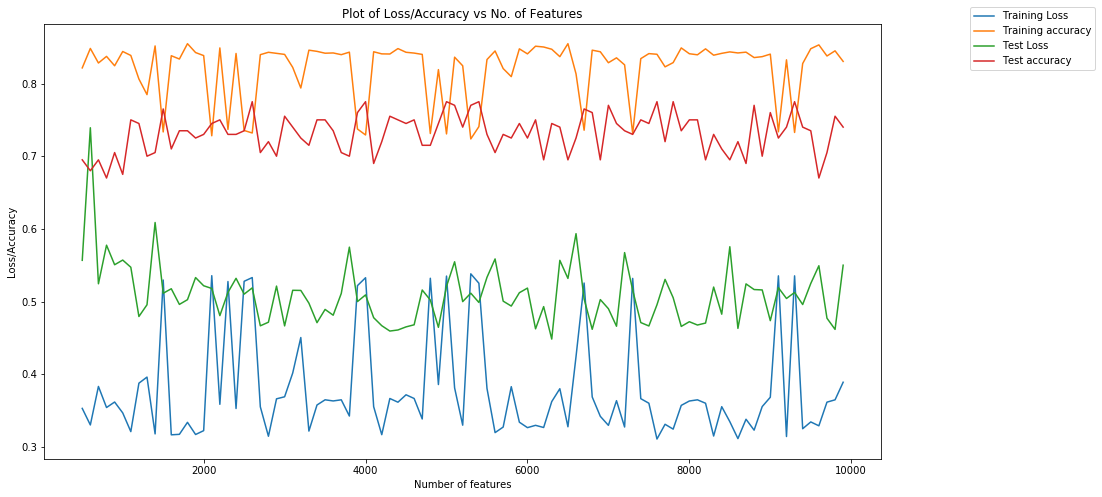

In [19]:
plt.rcParams['figure.figsize'] = (15, 8)

f = np.arange(start_feat, end_feat, step_feat)

#plt.subplot(221)
plt.plot(f, tr_loss, label='Training Loss')

#plt.subplot(222)
plt.plot(f, tr_acc, label='Training accuracy')

#plt.subplot(223)
plt.plot(f, ts_loss, label='Test Loss')

#plt.subplot(224)
plt.plot(f, ts_acc, label='Test accuracy')

plt.legend(bbox_to_anchor=(1.1, 1.05))

plt.xlabel("Number of features")
plt.ylabel("Loss/Accuracy")
plt.title("Plot of Loss/Accuracy vs No. of Features")

plt.show()

In [17]:
print model.predict(X_ts[0:20])

[[  5.69689543e-01   4.30310457e-01]
 [  5.69689543e-01   4.30310457e-01]
 [  6.61957078e-01   3.38042922e-01]
 [  4.54505547e-01   5.45494453e-01]
 [  6.12342503e-01   3.87657497e-01]
 [  9.99999998e-01   1.59369572e-09]
 [  8.09497001e-01   1.90502999e-01]
 [  5.72051439e-01   4.27948561e-01]
 [  6.75542540e-01   3.24457460e-01]
 [  6.30778393e-01   3.69221607e-01]
 [  4.56964257e-01   5.43035743e-01]
 [  5.83463197e-01   4.16536803e-01]
 [  1.31149613e-01   8.68850387e-01]
 [  9.99999824e-01   1.76004363e-07]
 [  6.27069978e-01   3.72930022e-01]
 [  6.79499409e-01   3.20500591e-01]
 [  5.95529672e-01   4.04470328e-01]
 [  7.02956148e-01   2.97043852e-01]
 [  8.09497001e-01   1.90502999e-01]
 [  5.69689543e-01   4.30310457e-01]]


In [24]:
print model.predict(X_ts[0:20])

[[  9.99999944e-01   5.58455853e-08]
 [  1.00000000e+00   2.99722810e-10]
 [  5.06029170e-01   4.93970830e-01]
 [  5.06029170e-01   4.93970830e-01]
 [  9.99999868e-01   1.32425045e-07]
 [  9.99999980e-01   1.99602362e-08]
 [  5.06029170e-01   4.93970830e-01]
 [  5.06029170e-01   4.93970830e-01]
 [  5.06029170e-01   4.93970830e-01]
 [  5.06029170e-01   4.93970830e-01]
 [  5.07436490e-01   4.92563510e-01]
 [  5.06027682e-01   4.93972318e-01]
 [  5.06029170e-01   4.93970830e-01]
 [  5.06029170e-01   4.93970830e-01]
 [  9.99999999e-01   1.17829729e-09]
 [  1.00000000e+00   3.32733742e-10]
 [  5.06029170e-01   4.93970830e-01]
 [  5.06029170e-01   4.93970830e-01]
 [  5.06028193e-01   4.93971807e-01]
 [  9.99999980e-01   1.99602362e-08]]


In [18]:
print X_ts[0:20,0:20]

[[-1.  1.  1. -1.  1.  1. -1.  1.  1.  1. -1.  1. -1.  1. -1. -1.  1.  1.
  -1.  1.]
 [-1.  1.  1. -1.  1.  1. -1.  1.  1.  1. -1.  1. -1.  1. -1. -1.  1.  1.
  -1.  1.]
 [ 1. -1. -1.  1.  1. -1.  1.  1. -1.  1.  1. -1.  1.  1.  1. -1. -1.  1.
   1. -1.]
 [ 1. -1. -1.  1.  1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1. -1.
  -1.  1.]
 [ 1. -1.  1.  1. -1.  1.  1. -1.  1.  1. -1.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 1. -1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1.  1.
   1.  1.]
 [ 1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1. -1.  1.  1. -1.  1.
   1. -1.]
 [ 1. -1.  1.  1. -1.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 1. -1. -1.  1.  1. -1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1. -1.  1.
   1. -1.]
 [ 1. -1. -1.  1.  1.  1. -1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1. -1.
  -1.  1.]
 [ 1. -1. -1.  1.  1. -1.  1.  1. -1.  1.  1.  1. -1.  0.  0.  0.  0.  0.
   0.  0.]
 [ 1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1. -1.  1.

In [11]:
print y_ts[0:20]

[[ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]]
